In [19]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

In [9]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(), #переворачиваем с p 0.5
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/drive/MyDrive/ITMO/CV/Lab_3/data/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [10]:
print(dataset_sizes)

{'train': 226, 'val': 101}


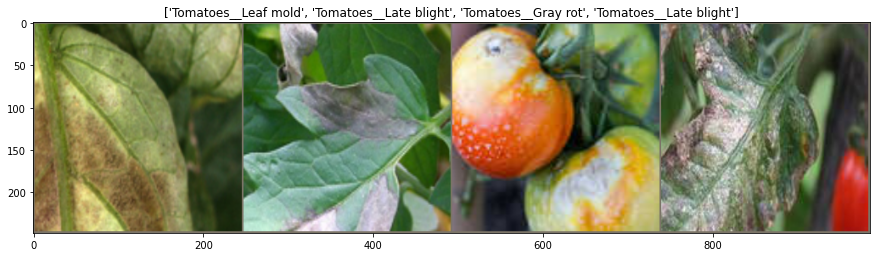

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [22]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [23]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

In [24]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [25]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
num_features = 9216
model.classifier = nn.Linear(num_features, 10)
if use_gpu:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [28]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

Training complete in 12m 23s
Best val Acc: 0.861386


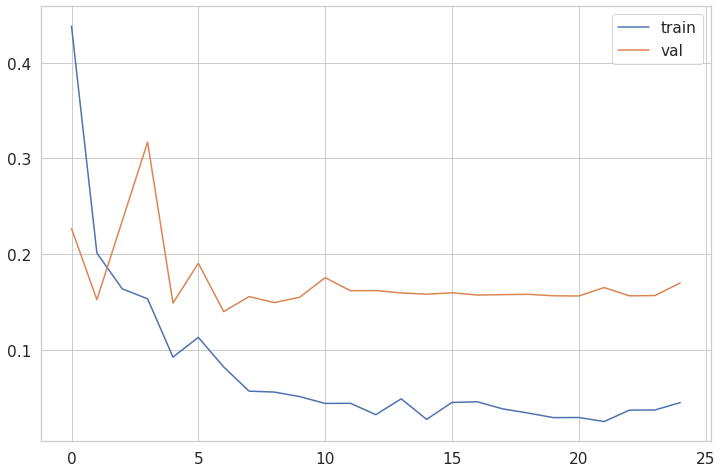

In [29]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)


plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [31]:
class_names

['Apples__Canker',
 'Apples__Monilia',
 'Apples__Powdery mildew',
 'Apples__Сedar rust',
 'Corn__Eyespot',
 'Corn__Northern leaf blight',
 'Corn__Southern rust',
 'Tomatoes__Gray rot',
 'Tomatoes__Late blight',
 'Tomatoes__Leaf mold']

In [40]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [41]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

<All keys matched successfully>

In [42]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.8119


In [130]:
x = torch.arange(1., 6.)
value_5, index_5 = torch.topk(x, 3)
index_5

tensor([4, 3, 2])

In [137]:
def top_5 (arr):
  return torch.topk(arr, 5)

  


import torch
y = []
predY = []
pred_top5 = []
for data in tqdm(dataloaders['val'], leave=False, desc=f"val iter:"):
  # получаем картинки и метки
  inputs, labels = data

  # оборачиваем в переменные
  if use_gpu:
      inputs = inputs.cuda()
      labels = labels.cuda()
  else:
      inputs, labels = inputs, labels
      
  outputs = model(inputs)
  for (i, j) in zip(outputs, labels):
    value_5, index_5 = top_5(i)
    print(index_5)
    if j in index_5:
      pred_top5.append(1)

  preds = torch.argmax(outputs, -1)

  for i, j in zip(labels, preds):
    y.append(i)
    predY.append(j)

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

tensor([5, 4, 9, 3, 8])
tensor([2, 8, 5, 1, 9])
tensor([5, 0, 4, 8, 3])
tensor([2, 8, 3, 7, 0])
tensor([3, 4, 6, 0, 9])
tensor([7, 8, 1, 2, 3])
tensor([2, 5, 8, 9, 3])
tensor([1, 7, 8, 0, 4])
tensor([3, 4, 5, 7, 9])
tensor([0, 8, 1, 5, 7])
tensor([6, 4, 3, 0, 5])
tensor([0, 8, 1, 7, 5])
tensor([6, 4, 3, 1, 0])
tensor([3, 8, 0, 4, 1])
tensor([1, 0, 8, 6, 7])
tensor([0, 8, 7, 1, 3])
tensor([1, 0, 4, 7, 3])
tensor([0, 8, 1, 7, 5])
tensor([6, 4, 3, 1, 0])
tensor([6, 4, 0, 5, 7])
tensor([2, 8, 0, 7, 9])
tensor([1, 0, 6, 7, 8])
tensor([2, 8, 5, 3, 9])
tensor([9, 2, 8, 0, 7])
tensor([5, 8, 3, 9, 7])
tensor([0, 7, 1, 4, 8])
tensor([3, 4, 6, 0, 7])
tensor([4, 5, 6, 9, 3])
tensor([8, 3, 0, 1, 7])
tensor([3, 6, 0, 8, 7])
tensor([0, 8, 1, 7, 5])
tensor([8, 3, 9, 7, 0])
tensor([1, 0, 8, 7, 6])
tensor([3, 6, 8, 7, 9])
tensor([7, 8, 3, 1, 9])
tensor([6, 4, 0, 3, 1])
tensor([5, 4, 6, 3, 2])
tensor([3, 8, 6, 7, 5])
tensor([0, 5, 1, 8, 7])
tensor([3, 6, 4, 7, 0])
tensor([9, 8, 3, 4, 5])
tensor([0, 1, 7,

In [138]:
a = [i for i, j in zip(y, predY) if i == j]
print(f"Top-1 accuracy {len(a)/len(y)}")

Top-1 accuracy 0.8118811881188119


In [139]:
a = [i for i, j in zip(y, predY) if i != j]
print(f"Top-5 accuracy {len(pred_top5)/len(y)}")

Top-5 accuracy 0.9801980198019802


# VGG 16

In [76]:
model_VGG = models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [77]:
model_VGG

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [78]:

num_features = 25088

model_VGG.classifier = nn.Linear(num_features, 10)
if use_gpu:
    model_VGG = model_VGG.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_VGG.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [79]:
model_VGG, losses = train_model(model_VGG, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

Training complete in 202m 55s
Best val Acc: 0.910891


In [85]:
torch.save(model_VGG.state_dict(), 'vgg.pth')

In [86]:
model_VGG.load_state_dict(torch.load('vgg.pth'))

<All keys matched successfully>

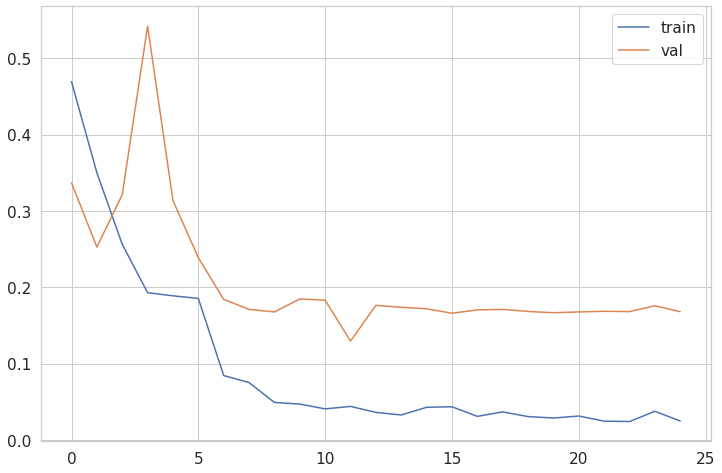

In [82]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)


plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [87]:
print("Accuracy: {0:.4f}".format(evaluate(model_VGG)))

Accuracy: 0.8614


In [140]:
def top_5 (arr):
  return torch.topk(arr, 6)

  


import torch
y = []
predY = []
pred_top5 = []
for data in tqdm(dataloaders['val'], leave=False, desc=f"val iter:"):
  # получаем картинки и метки
  inputs, labels = data

  # оборачиваем в переменные
  if use_gpu:
      inputs = inputs.cuda()
      labels = labels.cuda()
  else:
      inputs, labels = inputs, labels
      
  outputs = model_VGG(inputs)
  for (i, j) in zip(outputs, labels):
    value_5, index_5 = top_5(i)
    print(index_5)
    if j in index_5:
      pred_top5.append(1)

  preds = torch.argmax(outputs, -1)

  for i, j in zip(labels, preds):
    y.append(i)
    predY.append(j)

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

tensor([2, 8, 5, 7, 9, 0])
tensor([5, 6, 4, 1, 7, 3])
tensor([6, 4, 3, 0, 1, 9])
tensor([5, 4, 0, 7, 2, 6])
tensor([8, 7, 0, 1, 2, 9])
tensor([1, 7, 5, 4, 3, 8])
tensor([5, 4, 7, 3, 9, 1])
tensor([7, 8, 1, 9, 5, 3])
tensor([9, 8, 7, 3, 2, 0])
tensor([8, 7, 0, 1, 2, 9])
tensor([6, 4, 3, 1, 0, 9])
tensor([9, 8, 7, 3, 1, 4])
tensor([7, 5, 4, 1, 3, 0])
tensor([6, 4, 3, 1, 5, 0])
tensor([8, 7, 0, 2, 1, 9])
tensor([0, 8, 1, 4, 3, 7])
tensor([7, 8, 1, 5, 9, 0])
tensor([9, 8, 7, 3, 1, 4])
tensor([7, 1, 8, 0, 5, 9])
tensor([3, 6, 1, 4, 8, 0])
tensor([5, 4, 1, 0, 6, 2])
tensor([7, 8, 1, 5, 9, 2])
tensor([6, 4, 3, 5, 0, 1])
tensor([6, 4, 1, 5, 3, 0])
tensor([1, 7, 6, 0, 8, 4])
tensor([3, 1, 6, 7, 8, 0])
tensor([3, 1, 6, 4, 8, 0])
tensor([2, 8, 0, 5, 1, 9])
tensor([5, 1, 2, 3, 0, 4])
tensor([3, 6, 1, 8, 4, 0])
tensor([4, 6, 5, 3, 1, 0])
tensor([2, 8, 0, 5, 1, 7])
tensor([3, 6, 1, 4, 0, 8])
tensor([7, 8, 1, 9, 3, 5])
tensor([2, 8, 9, 5, 1, 7])
tensor([6, 4, 3, 0, 1, 8])
tensor([0, 1, 8, 7, 3, 5])
t

In [141]:
a = [i for i, j in zip(y, predY) if i == j]
print(f"Top-1 accuracy {len(a)/len(y)}")

Top-1 accuracy 0.8613861386138614


In [142]:
a = [i for i, j in zip(y, predY) if i != j]
print(f"Top-5 accuracy {len(pred_top5)/len(y)}")

Top-5 accuracy 1.0


# Mobile Net


In [143]:
model_MOBILE = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [144]:
model_MOBILE

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [145]:

num_features = 1280

model_MOBILE.classifier = nn.Linear(num_features, 10)
if use_gpu:
    model_MOBILE = model_MOBILE.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_MOBILE.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [146]:
model_MOBILE, losses = train_model(model_MOBILE, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

Training complete in 23m 5s
Best val Acc: 0.910891


In [154]:
torch.save(model_MOBILE.state_dict(), 'mobile.pth')

In [155]:
model_MOBILE.load_state_dict(torch.load('mobile.pth'))

<All keys matched successfully>

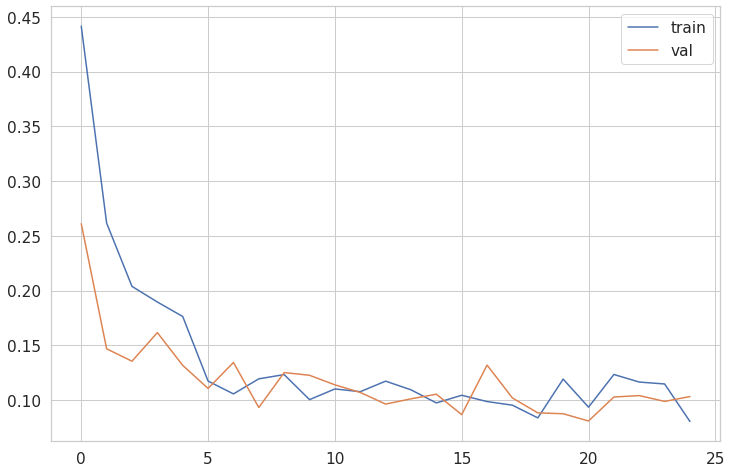

In [156]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)


plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [157]:
print("Accuracy: {0:.4f}".format(evaluate(model_MOBILE)))

Accuracy: 0.8713


In [158]:
def top_5 (arr):
  return torch.topk(arr, 6)

  


import torch
y = []
predY = []
pred_top5 = []
for data in tqdm(dataloaders['val'], leave=False, desc=f"val iter:"):
  # получаем картинки и метки
  inputs, labels = data

  # оборачиваем в переменные
  if use_gpu:
      inputs = inputs.cuda()
      labels = labels.cuda()
  else:
      inputs, labels = inputs, labels
      
  outputs = model_MOBILE(inputs)
  for (i, j) in zip(outputs, labels):
    value_5, index_5 = top_5(i)
    print(index_5)
    if j in index_5:
      pred_top5.append(1)

  preds = torch.argmax(outputs, -1)

  for i, j in zip(labels, preds):
    y.append(i)
    predY.append(j)

val iter::   0%|          | 0/26 [00:00<?, ?it/s]

tensor([1, 8, 7, 3, 0, 4])
tensor([2, 3, 0, 5, 7, 9])
tensor([7, 1, 3, 8, 9, 5])
tensor([6, 3, 4, 0, 8, 1])
tensor([3, 6, 5, 9, 7, 1])
tensor([8, 9, 0, 5, 2, 3])
tensor([5, 4, 7, 2, 0, 8])
tensor([0, 5, 7, 8, 2, 9])
tensor([2, 7, 0, 8, 1, 4])
tensor([7, 2, 5, 8, 3, 9])
tensor([2, 8, 5, 1, 7, 3])
tensor([4, 6, 5, 9, 7, 1])
tensor([2, 0, 5, 3, 7, 1])
tensor([2, 3, 8, 0, 5, 1])
tensor([5, 4, 7, 2, 6, 1])
tensor([5, 7, 4, 2, 6, 9])
tensor([8, 7, 9, 5, 0, 2])
tensor([7, 1, 3, 5, 6, 8])
tensor([5, 7, 4, 2, 6, 8])
tensor([5, 4, 7, 3, 6, 1])
tensor([8, 2, 7, 1, 5, 9])
tensor([5, 4, 7, 6, 2, 3])
tensor([2, 8, 7, 9, 5, 3])
tensor([2, 5, 9, 8, 0, 3])
tensor([4, 5, 7, 2, 8, 6])
tensor([9, 7, 4, 8, 2, 5])
tensor([1, 8, 2, 4, 3, 7])
tensor([8, 7, 9, 5, 0, 4])
tensor([0, 5, 4, 8, 7, 2])
tensor([0, 5, 2, 4, 8, 6])
tensor([0, 6, 7, 5, 9, 8])
tensor([0, 9, 5, 8, 2, 7])
tensor([0, 5, 9, 7, 6, 4])
tensor([3, 1, 6, 8, 2, 7])
tensor([5, 4, 2, 7, 9, 6])
tensor([9, 8, 2, 0, 7, 3])
tensor([5, 4, 7, 2, 9, 6])
t

In [159]:
a = [i for i, j in zip(y, predY) if i == j]
print(f"Top-1 accuracy {len(a)/len(y)}")

Top-1 accuracy 0.8712871287128713


In [160]:
a = [i for i, j in zip(y, predY) if i != j]
print(f"Top-5 accuracy {len(pred_top5)/len(y)}")

Top-5 accuracy 1.0
